### First things First - Make notebook to connect with current directory

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun 30 05:55:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import auth
auth.authenticate_user()

In [6]:
### For working on google colab

from google.colab import drive

drive.mount('/content/gdrive')
cur_dir = 'gdrive/My Drive/SRGAN Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
import sys
# cur_dir = '~/srgan-project'
sys.path.append(cur_dir)

In [8]:
import os 
os.chdir(cur_dir)
os.getcwd()

'/content/gdrive/My Drive/SRGAN Project'

In [9]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

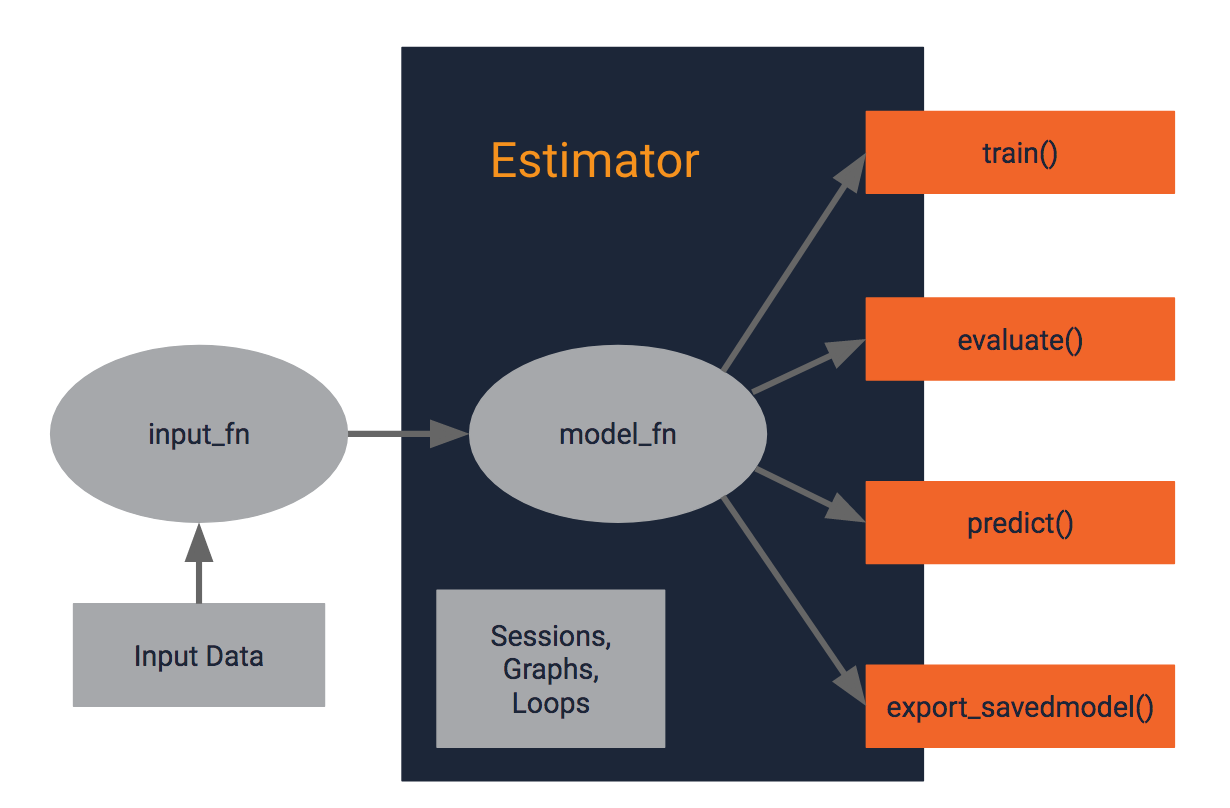

In [10]:

### Image is taken from CRAN : https://cran.r-project.org/web/packages/tfestimators/vignettes/creating_estimators.html 


from IPython.display import Image, display
display(Image(filename = 'estimator_BD.png'))

### GPU

In [11]:

### Installing tensorflow packages

# !pip install tensorflow==1.15
!pip install tensorflow-gan

# !pip install pyfastcopy
# !pip install tensorflow-gpu==2.1.0


     |████████████████████████████████| 368kB 4.7MB/s 


In [12]:
%tensorflow_version 2.x

import tensorflow as tf

# tf.disable_v2_behavior()
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.2.0
Num GPUs Available:  1


In [13]:
tf.random.set_seed(10)

In [14]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [15]:


tf.debugging.set_log_device_placement(True)

In [16]:


gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(gpus[0], True)

run_config_strategy = "SINGLE"

if gpus and run_config_strategy == "MULTI":
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


In [17]:


# tf.config.set_soft_device_placement(True)
all_logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(all_logical_gpus)



[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [18]:
import time
model_dir = '{}'.format(
   time.strftime('gpuestimator-tfgan/%Y-%m-%d-%H-%M-%S'))
print('Using model dir: {}'.format(model_dir))

Using model dir: gpuestimator-tfgan/2020-06-30-05-56-48


In [19]:
model_dir = "gpuestimator-tfgan/saved-mseloss_tf2"

In [20]:
steps_per_eval = 350 #@param #steps per eval = training size/batch size

In [21]:
##### GPU configuration

gpu_strategy = None

if (len(all_logical_gpus) > 1):
  gpu_strategy = tf.distribute.MirroredStrategy()
else:
  gpu_strategy = tf.distribute.OneDeviceStrategy(device = tf.config.experimental.list_logical_devices('GPU')[0].name )

gpu_config = tf.estimator.RunConfig(tf_random_seed = 10, model_dir = model_dir ,
    train_distribute = gpu_strategy , eval_distribute = gpu_strategy, save_summary_steps= steps_per_eval, save_checkpoints_steps = steps_per_eval, keep_checkpoint_max = 1)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.


In [22]:
gpu_strategy

## Import Libraries

In [23]:
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning )
warnings.simplefilter("ignore", UserWarning)

In [24]:
import numpy as np
np.set_printoptions(precision=4)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

In [25]:
### python 

from collections import defaultdict
import itertools

import h5py


In [26]:
# Check that imports for the rest of the file work.

import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Disable noisy outputs.

In [27]:
print(tfgan.__version__)

2.0.0


In [28]:
### USED WHEN RUNNING ON GPUs for loss aggregations 

from tensorflow.python.keras.utils import losses_utils

In [29]:
import pydot

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model



Using TensorFlow backend.


In [30]:
%load_ext autoreload
%autoreload 2
from PIL import Image
import cv2
from tensorflow.keras.models import load_model


In [31]:

# Disable noisy output.
tf.autograph.set_verbosity(0, False)

In [32]:
import time
from pathlib import Path
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

#### Train Input Pipeline

In [33]:
root_path = ""
train_data_path = "data/DIV2K_train_HR/hr_images/*"
valid_data_path = "data/DIV2K_valid_HR/*"

In [34]:
tf.compat.v1.set_random_seed(10)
discriminator_img_shape = (96, 96)
original_img_shape = (2048, 1080)
generator_img_shape = (24, 24)

In [35]:
from preprocess_file_py import *

In [36]:
def input_fn(mode, params):
  
  with tf.name_scope("Training_Input_Feeding_Block"):
    ## check the inputs presence
    assert 'batch_size' in params
    assert 'original_img_shape' in params
    assert 'generator_img_shape' in params
    assert 'discriminator_img_shape' in params
    assert 'root_path' in params
    assert 'train_data_path' in params
    assert 'valid_data_path' in params

    ## Assign the inputs to local variables
    bs = params['batch_size']
    original_image_shape = params['original_img_shape']
    generator_img_shape = params['generator_img_shape']
    discriminator_img_shape = params['discriminator_img_shape']
    root_path = params['root_path']
    train_data_path = params['train_data_path']
    valid_data_path = params['valid_data_path']
    
    ### FLAGS 
    split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
    # shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
    shuffle = False
    just_lrimage = (mode == tf.estimator.ModeKeys.PREDICT)

    with tf.name_scope("Train_Preprocess_Input"):
      ## load the images and preprocess them to get low and high resolution images using function "preprocess_load" implemented 
      lr_hr_images_ds = preprocess_load(root_path=root_path,hr_image_shape = discriminator_img_shape , \
                                          lr_image_shape = generator_img_shape, original_image_shape = original_img_shape ,
                                          show_images = False , data_path = train_data_path)

    images_ds = lr_hr_images_ds

    lowres_images_ds = (images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
                        .batch(bs, drop_remainder = True).repeat()) 

    ## For prediction, output only the low resolution images
    if just_lrimage:
      return lowres_images_ds

    ### Prepare the data for training the model
    highres_images = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))
    highres_images_ds = (highres_images.batch(bs, drop_remainder=True).repeat())


    if shuffle:
      # images_ds = tf.data.Dataset.zip((lowres_images, highres_images))
      images_ds = lr_hr_images_ds.shuffle(buffer_size=10000, seed =10, reshuffle_each_iteration=True )
      
      lowres_images_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img)).cache()
      lowres_images_ds = (lowres_images_ds.batch(bs, drop_remainder = True).repeat().prefetch(tf.data.experimental.AUTOTUNE))

      highres_images_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img)).cache()
      highres_images_ds = (highres_images_ds.batch(bs, drop_remainder=True).repeat()
                          .prefetch(tf.data.experimental.AUTOTUNE))
      

    return tf.data.Dataset.zip((lowres_images_ds, highres_images_ds))

In [37]:
train_check_params = {'batch_size': 8 , 'discriminator_img_shape' : discriminator_img_shape , 'generator_img_shape' : generator_img_shape , 'original_img_shape' : original_img_shape,
          'root_path' : root_path, 'train_data_path' : train_data_path , 'valid_data_path' : valid_data_path }

In [38]:
train_ds = input_fn(tf.estimator.ModeKeys.TRAIN, train_check_params)


Executing op MatchingFiles in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Greater in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReduceJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op InterleaveDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op InterleaveDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:loc

In [39]:
train_ds

<ZipDataset shapes: ((8, 24, 24, 3), (8, 96, 96, 3)), types: (tf.float32, tf.float32)>

In [40]:
lwres_images_ds = train_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
hgres_images_ds = train_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))

Executing op InterleaveDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op InterleaveDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [41]:
lwres_images_ds.take(1)

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0


<TakeDataset shapes: (8, 24, 24, 3), types: tf.float32>

##### CHECK THE INPUT PIPELINE 

In [42]:
def show_hr_image(image, label = 'high resolution image example', img_ids_hr = 1):
    # image = (tf.cast(image, tf.float32) * 127.5 ) + 127.5
    image = (tf.cast(image, tf.float32) + 1.0 ) / 2.0
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    # plt.savefig(root_path + "example_images/highres/img_{}.png" .format(img_ids_hr ) )


def show_lr_image(image, label = 'low resolution image example', img_ids_lr = 1):
    # image = (tf.cast(image, tf.float32) * 255.0 ) 
    image = (tf.cast(image, tf.float32) )
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    # plt.savefig(root_path + "example_images/lowres/img{}.png" .format(img_ids_lr ) )

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


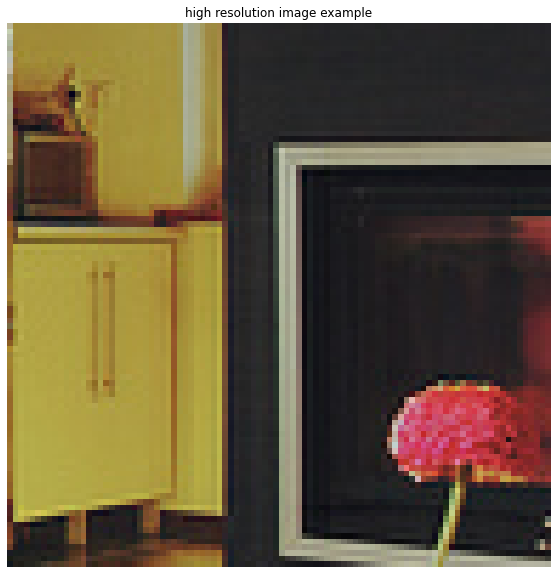

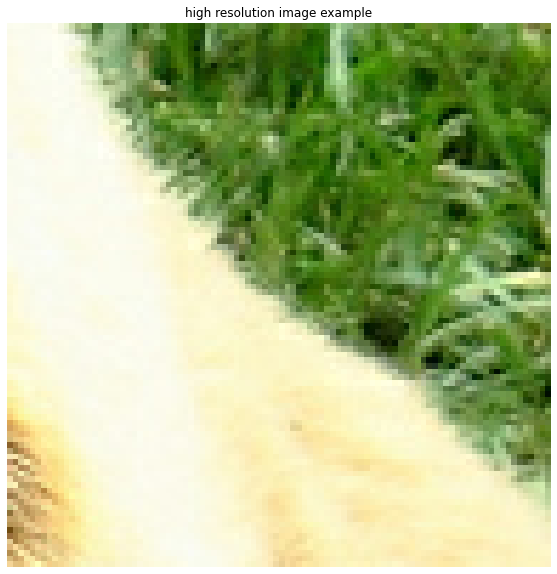

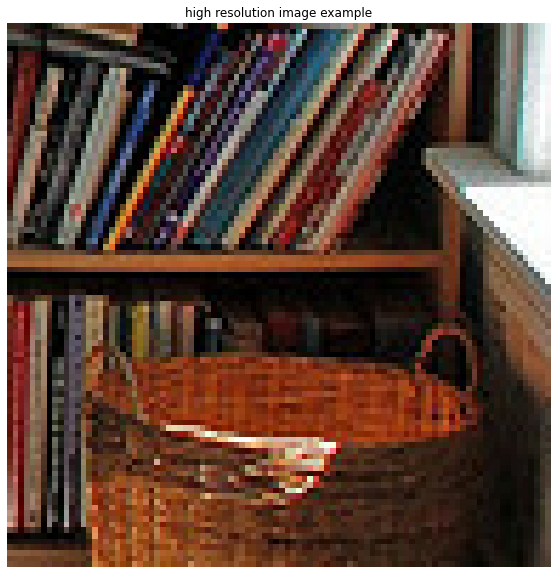

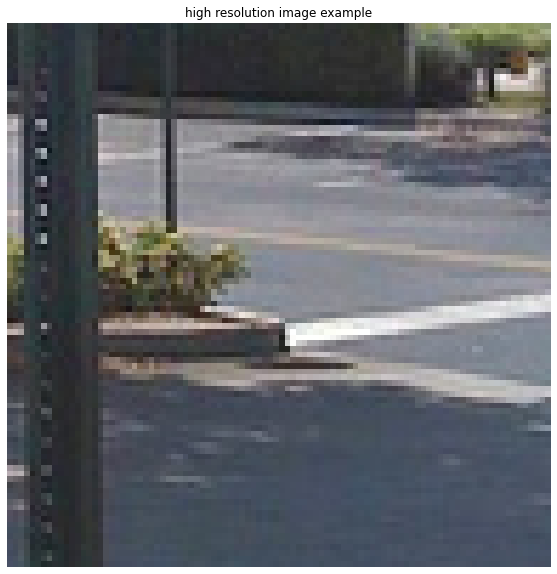

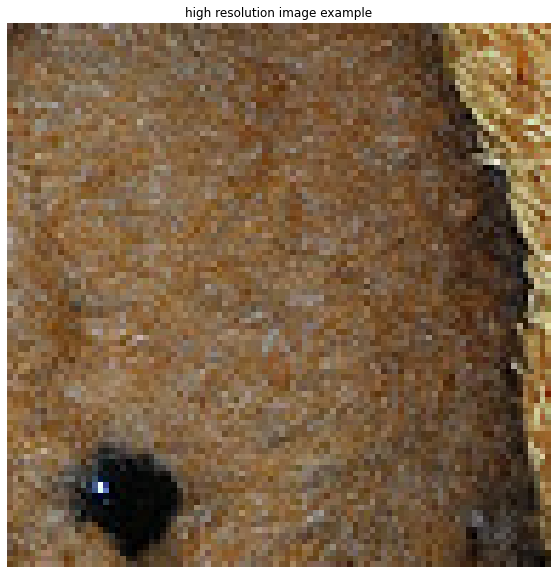

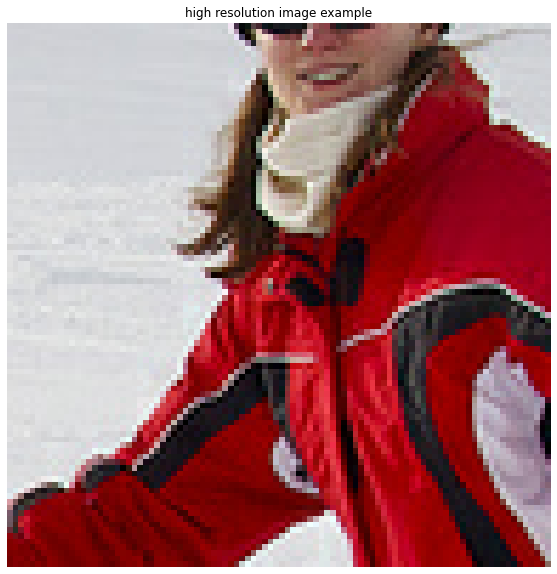

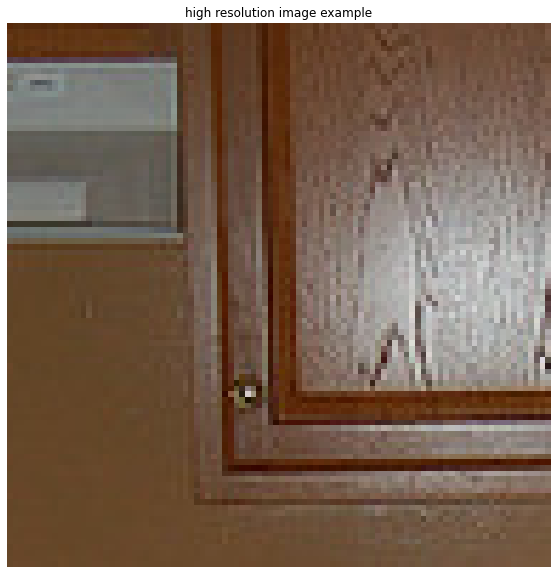

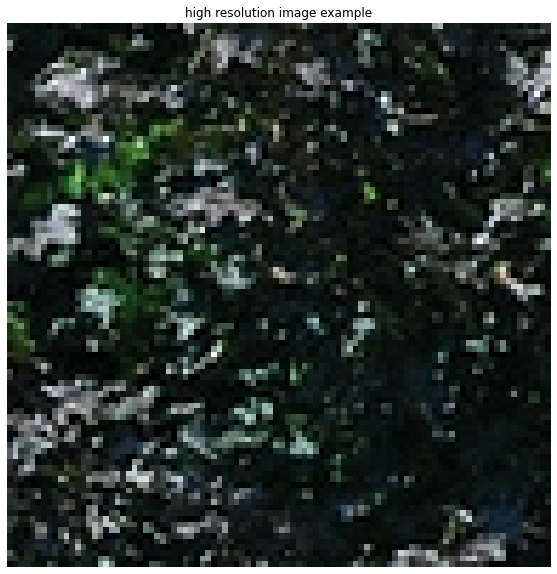

In [43]:
### show high resolution images 

for image1 in hgres_images_ds.take(1):  
  for i, image2 in enumerate(image1[0:10]):
    show_hr_image(image2)
    

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


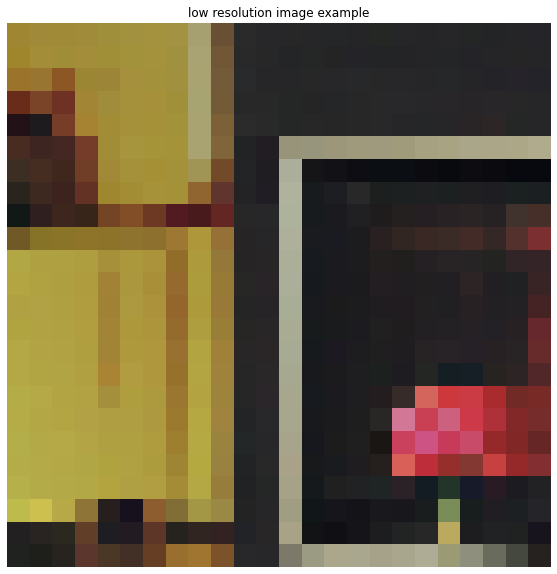

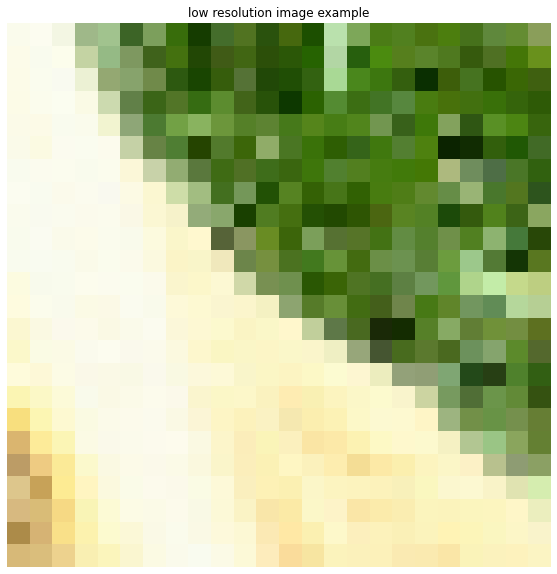

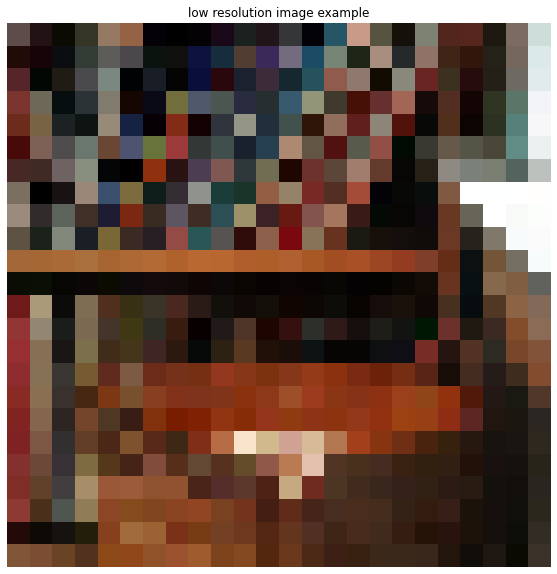

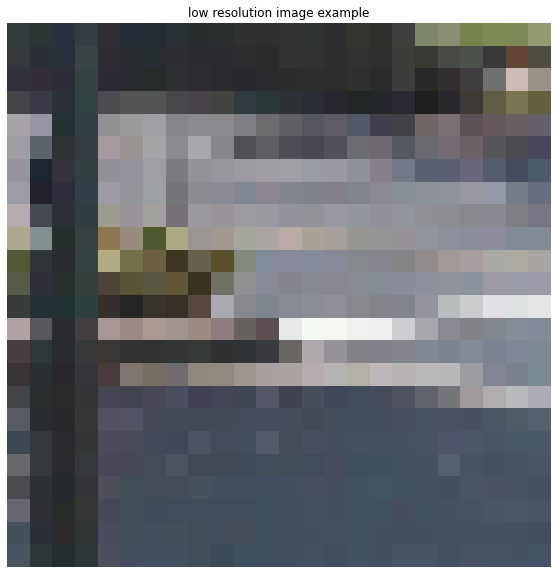

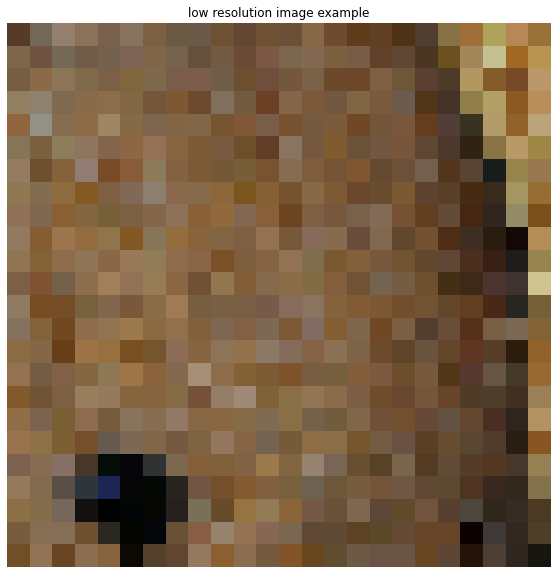

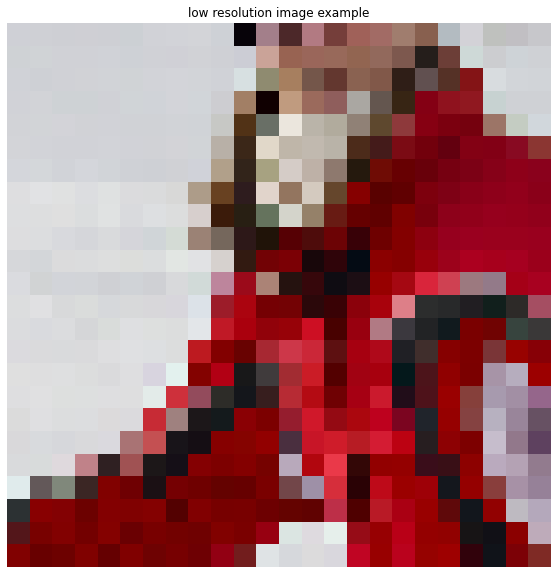

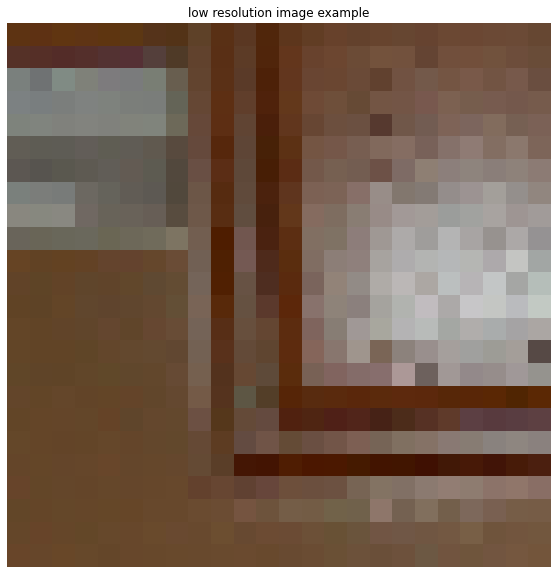

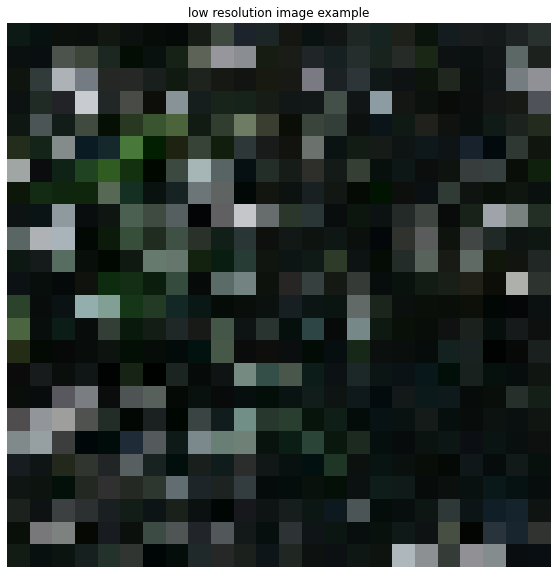

In [44]:
### show low resolution images 

for image1 in lwres_images_ds.take(1):  
    for i, image2 in enumerate(image1[0:10]):
      show_lr_image(image2, img_ids_lr = i+1)
    

**Download the data and sanity check the inputs.**

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Low resolution images training batch 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


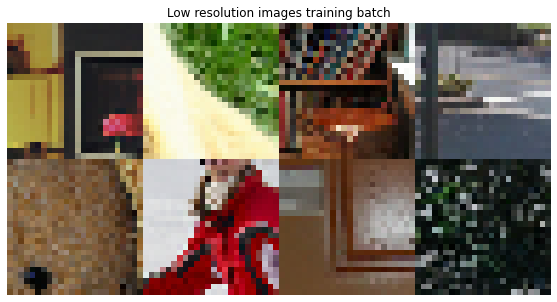

High resolution images training batch 


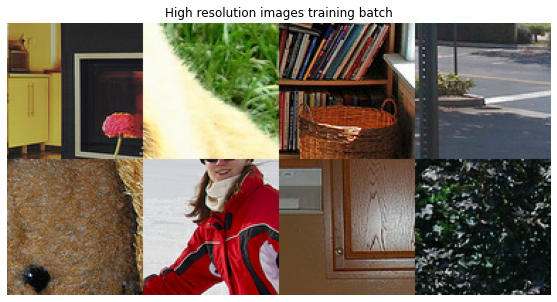

In [45]:

numpy_imgs = next(tfds.as_numpy(train_ds))[0]
numpy_imgs1 = next(tfds.as_numpy(train_ds))[1]
numpy_imgs1 = ( numpy_imgs1 + 1.0 ) / 2.0

img_grid = tfgan.eval.python_image_grid(numpy_imgs , grid_shape=(2, 4))
print('Low resolution images training batch ')
plt.figure(figsize=(10,5))
plt.axis('off')
plt.title('Low resolution images training batch')
plt.imshow(np.squeeze(img_grid))
plt.savefig(root_path + "report_images/training_samples_lowres.png")
plt.show()

print('High resolution images training batch ')
img_grid1 = tfgan.eval.python_image_grid(numpy_imgs1 , grid_shape=(2, 4))
plt.figure(figsize=(10,5))
plt.axis('off')
plt.title('High resolution images training batch')
plt.imshow(np.squeeze(img_grid1))
plt.savefig(root_path + "report_images/training_samples_highres.png")
plt.show()

### Validation Input


In [46]:
def valid_input_fn(mode, params):
  
  with tf.name_scope("Validation_Input_Feeding_Block"):
    ## check the inputs presence
    assert 'batch_size' in params
    assert 'original_img_shape' in params
    assert 'generator_img_shape' in params
    assert 'discriminator_img_shape' in params
    assert 'root_path' in params
    assert 'train_data_path' in params
    assert 'valid_data_path' in params

    ## Assign the inputs to local variables
    bs = params['valid_batch_size']
    original_image_shape = params['original_img_shape']
    generator_img_shape = params['generator_img_shape']
    discriminator_img_shape = params['discriminator_img_shape']
    root_path = params['root_path']
    train_data_path = params['train_data_path']
    valid_data_path = params['valid_data_path']
    
    ### FLAGS 
    split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
    # shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
    shuffle = False
    just_lrimage = (mode == tf.estimator.ModeKeys.PREDICT)

    with tf.name_scope("Validation_Preprocess_Input"):
      ## load the images and preprocess them to get low and high resolution images using function "preprocess_load" implemented 
      lr_hr_images_ds = preprocess_load(root_path=root_path,hr_image_shape = discriminator_img_shape , \
                                          lr_image_shape = generator_img_shape, original_image_shape = original_img_shape ,
                                          show_images = False , data_path = train_data_path)

    images_ds = lr_hr_images_ds

    lowres_images_ds = (images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
                        .batch(bs, drop_remainder = True).repeat()) 

    ## For prediction, output only the low resolution images
    if just_lrimage:
      return lowres_images_ds

    ### Prepare the data for training the model
    highres_images = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))
    highres_images_ds = (highres_images.batch(bs, drop_remainder=True).repeat())


    if shuffle:
      # images_ds = tf.data.Dataset.zip((lowres_images, highres_images))
      images_ds = lr_hr_images_ds.shuffle(buffer_size=10000, seed =10, reshuffle_each_iteration=True )
      
      lowres_images_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img)).cache()
      lowres_images_ds = (lowres_images_ds.batch(bs, drop_remainder = True).repeat().prefetch(tf.data.experimental.AUTOTUNE))

      highres_images_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img)).cache()
      highres_images_ds = (highres_images_ds.batch(bs, drop_remainder=True).repeat()
                          .prefetch(tf.data.experimental.AUTOTUNE))
      

    return tf.data.Dataset.zip((lowres_images_ds, highres_images_ds))

In [47]:
valid_params = {'batch_size': 8 , 'valid_batch_size': 10 ,'discriminator_img_shape' : discriminator_img_shape , 'generator_img_shape' : generator_img_shape , 'original_img_shape' : original_img_shape,
          'root_path' : root_path, 'train_data_path' : train_data_path , 'valid_data_path' : valid_data_path }

In [48]:
valid_ds = valid_input_fn(tf.estimator.ModeKeys.EVAL, valid_params)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op InterleaveDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op InterleaveDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op InterleaveDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op InterleaveDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Execu

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Low resolution images training batch 


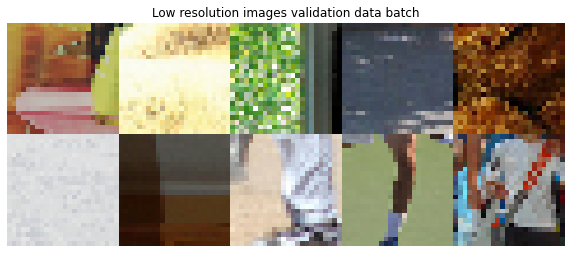

High resolution images training batch 


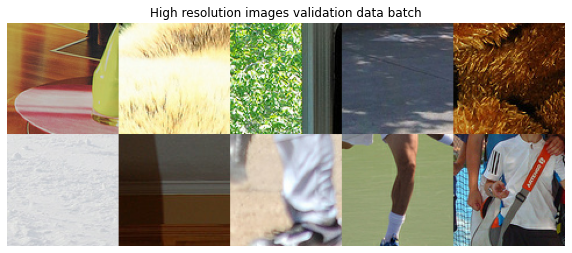

In [49]:

valid_numpy_imgs = next(tfds.as_numpy(valid_ds))[0]
valid_numpy_imgs1 = next(tfds.as_numpy(valid_ds))[1]
valid_numpy_imgs1 = ( valid_numpy_imgs1 + 1.0 ) / 2.0

valid_img_grid = tfgan.eval.python_image_grid(valid_numpy_imgs , grid_shape=(2, 5))
print('Low resolution images training batch ')
plt.figure(figsize=(10,5))
plt.axis('off')
plt.title('Low resolution images validation data batch')
plt.imshow(np.squeeze(valid_img_grid))
plt.savefig(root_path + "report_images/validation_samples_lowres")
plt.show()

print('High resolution images training batch ')
valid_img_grid1 = tfgan.eval.python_image_grid(valid_numpy_imgs1 , grid_shape=(2, 5))
plt.figure(figsize=(10,5))
plt.axis('off')
plt.title('High resolution images validation data batch')
plt.imshow(np.squeeze(valid_img_grid1))
plt.savefig(root_path + "report_images/validation_samples_highres")
plt.show()

### Neural Network Architectures

To build our GAN we need two separate networks:

*  A generator that takes input low-resolution image and outputs generated super-resolved image
*  A discriminator that takes images (both original high resolution and super-resolution ) and outputs a probability of being real or fake

We define functions that build these networks. In the GANEstimator section below we pass the builder functions to the `GANEstimator` constructor. `GANEstimator` handles hooking the generator and discriminator together into the GAN. 

In [50]:
from srgan_model_py import generator, discriminator

In [51]:

generator

<function srgan_model_py.generator>

In [52]:
discriminator

<function srgan_model_py.discriminator>

### Evaluation Metric, Loss Functions and optimizers

In [53]:
def get_eval_metric_ops_fn(gan_model):
  with tf.name_scope("Metrics_Computation_Block"):
    psnr_score = tf.image.psnr(gan_model.real_data, gan_model.generated_data, max_val=1.0)
  return {
      'psnr_score': tf.compat.v1.metrics.mean(psnr_score)
  }

#### Loss functions

In [54]:
### SET GLOBAL BATCH SIZE TO MINI_BATCH SIZE 
GLOBAL_BATCH_SIZE = 16
# mini_batch_size = 

In [55]:
from loss_function_utils import *
from optimizers_file_py import *
from model_utils import *

In [56]:
import loss_function_utils
loss_function_utils.GLOBAL_BATCH_SIZE = GLOBAL_BATCH_SIZE

In [57]:
### Set batch_size to 1/2 of global batch size in case of multiple gpus training i.e., GLOBAL_BATCH_SIZE = PER_REPLICA_BATHC_SIZE * NUM_OF_REPLICAS.
### Otherwise, use same as GLOBAL_BATCH_SIZE for single gpu training

params = {'batch_size': 16 , 'valid_batch_size': 16 ,'discriminator_img_shape' : discriminator_img_shape , 'generator_img_shape' : generator_img_shape , 'original_img_shape' : original_img_shape,
          'root_path' : root_path, 'train_data_path' : train_data_path , 'valid_data_path' : valid_data_path }

In [58]:

generator_lr = 0.0001 #@param
discriminator_lr = 0.0001 #@param

summaries_list = [tfgan.estimator.SummaryType.IMAGES, tfgan.estimator.SummaryType.VARIABLES]

gan_estimator = tfgan.estimator.GANEstimator(model_dir = model_dir,
    generator_fn = generator,
    discriminator_fn = discriminator,
    generator_loss_fn= MSE_loss,
    discriminator_loss_fn= discriminator_loss,
    params=params,
    generator_optimizer= tf.compat.v1.train.AdamOptimizer(generator_lr, 0.9),
    discriminator_optimizer = tf.compat.v1.train.AdamOptimizer(discriminator_lr, 0.9),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn,
    use_loss_summaries=True,  
    add_summaries = summaries_list ,
    config = gpu_config)

### Train and eval loop

In [59]:
## Check the GPUs running
tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [ ]:
### Run this cell if training the model from previous training steps. This makes training to start from last checkpoint of previous training.

previous_training_chkpt_step = 0
previous_training_best_chkpt_step = 0
best_chkpt_monitoring_variable = 0
best_chkpt_monitoring_path = 0

### NOTE: SET THIS VARIABLE TO GREATER THAN 1 IN CASE OF TRAINING FROM PREVIOUS TRAINED MODEL PARAMETERS
run_num = 0

if run_num >= 1:
    with open(model_dir + "/chkpt_file.txt", "r+") as chkpt_file:
        previous_training_best_chkpt_step = int(chkpt_file.readline().split(" ")[1])
        best_chkpt_monitoring_variable = float(chkpt_file.readline().split(" ")[1])
        try:
            previous_training_chkpt_step = int(chkpt_file.readline().split(" ")[1])
        except:
            previous_training_chkpt_step = previous_training_best_chkpt_step
            pass

print(" Best checkpoint from previous training : " + str(previous_training_best_chkpt_step) )
print(" Best psnr value from previous training : " + str(best_chkpt_monitoring_variable) )
print(" Last checkpoint from previous training : " + str(previous_training_chkpt_step) ) 

 Best checkpoint from previous training : 0
 Best psnr value from previous training : 0
 Last checkpoint from previous training : 0


Time since start: 41.88 min
Trained from step 0 to 350 in 0.14 steps / sec
PSNR Score on train data: 15.230   
PSNR Score on validation data: 15.190   
gpuestimator-tfgan/saved-mseloss_tf2/model.ckpt-350.*
Following file is copied to best model directory :gpuestimator-tfgan/saved-mseloss_tf2/model.ckpt-350.data-00000-of-00001
Following file is copied to best model directory :gpuestimator-tfgan/saved-mseloss_tf2/model.ckpt-350.index
Following file is copied to best model directory :gpuestimator-tfgan/saved-mseloss_tf2/model.ckpt-350.meta


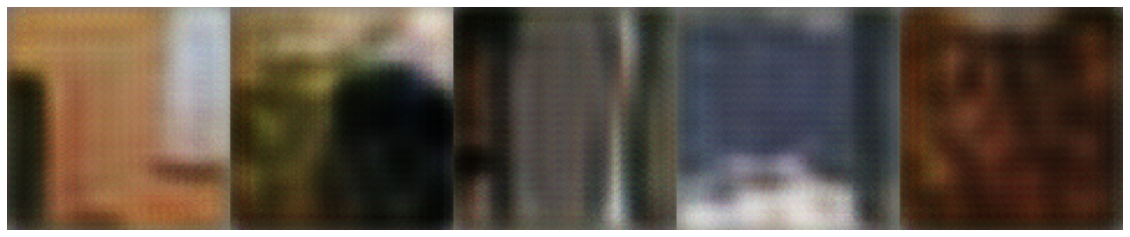

Time since start: 59.69 min
Trained from step 350 to 700 in 0.34 steps / sec
PSNR Score on train data: 16.994   
PSNR Score on validation data: 16.611   
gpuestimator-tfgan/saved-mseloss_tf2/model.ckpt-700.*
Following file is copied to best model directory :gpuestimator-tfgan/saved-mseloss_tf2/model.ckpt-700.data-00000-of-00001
Following file is copied to best model directory :gpuestimator-tfgan/saved-mseloss_tf2/model.ckpt-700.index
Following file is copied to best model directory :gpuestimator-tfgan/saved-mseloss_tf2/model.ckpt-700.meta


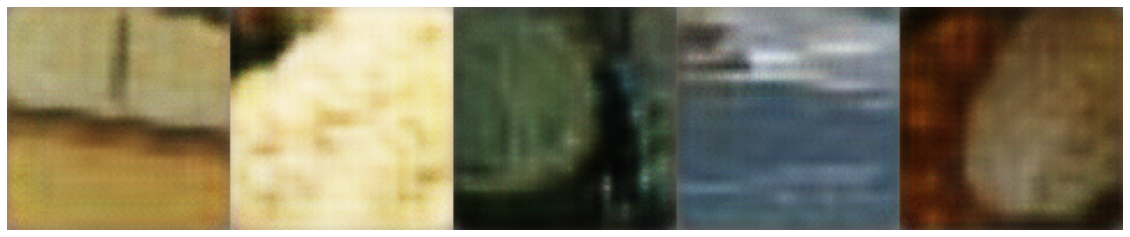

KeyboardInterrupt: ignored

In [ ]:
# Disable noisy output.
tf.autograph.set_verbosity(0, False)


num_of_epoch = 5 #@param

steps_per_eval = steps_per_eval #@param (num of images in train / batch_size = all mini batches)
max_train_steps = num_of_epoch * steps_per_eval # (num of epochs * (num of images in train / batch_size) )
batches_for_eval_metrics = 10 #@param  ### (In general, Num of images / batch_size = 200 / 16)


# Used to track metrics.
steps = []
train_psnr_scores = []
valid_psnr_scores = []


cur_step = 0
entered_training_loop = False
start_time = time.time()

## To make sure training starts from the latest chkpt file
if previous_training_chkpt_step > cur_step:
    cur_step = previous_training_chkpt_step

while cur_step < max_train_steps:
    next_step = min(cur_step + steps_per_eval, max_train_steps)
    entered_training_loop = True

    start = time.time()
    gan_estimator.train(input_fn, steps = steps_per_eval )
    steps_taken = next_step - cur_step
    time_taken = time.time() - start
    print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
    print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
    cur_step = next_step


    ########### On validation data ####################
    # Calculate some metrics on train and validation datasets.
    train_metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics, name='train_data')
    train_psnr_scores.append(train_metrics['psnr_score'])
    print('PSNR Score on train data: %.3f   ' % (train_psnr_scores[-1]))
    valid_metrics = gan_estimator.evaluate(valid_input_fn, steps=batches_for_eval_metrics, name='validation_data')
    steps.append(cur_step)
    valid_psnr_scores.append(valid_metrics['psnr_score'])
    print('PSNR Score on validation data: %.3f   ' % (valid_psnr_scores[-1]))

    ## Use Custom Function to save the best model, if psnr_score is best
    if (valid_metrics['psnr_score'] >= best_chkpt_monitoring_variable):
        best_chkpt_monitoring_variable = valid_metrics['psnr_score']
        best_chkpt_monitoring_path = cur_step
        best_model_saver(model_dir , best_chkpt_monitoring_path , best_chkpt_monitoring_variable)


    # Vizualize some images from predictions on validation data.
    valid_iterator = gan_estimator.predict(
          valid_input_fn, hooks=[tf.compat.v1.train.StopAtStepHook(num_steps=21)])
    try:
        valid_imgs = np.array([next(valid_iterator) for _ in range(5)])
    except StopIteration:
        pass
    valid_tiled = tfgan.eval.python_image_grid((valid_imgs + 1.0) /2.0 , grid_shape=(1, 5))


    plt.figure(figsize=(20,5))
    plt.axis('off')
    plt.imshow(np.squeeze(valid_tiled))
    plt.savefig(root_path + "report_images/generated_mseloss/valid_images_{}.png" .format(cur_step))
    plt.show()

if entered_training_loop:
      with open(model_dir + "/chkpt_file.txt","a+") as best_chkpt_file:
            best_chkpt_file.write("last_step" + " " + str(min(cur_step, max_train_steps) ) + "\n" )




In [ ]:

### Plot the metrics vs step - train.
plt.title('PSNR score per step - Train data')
plt.plot(steps, train_psnr_scores)
plt.xlabel('train and evaluate steps')
plt.ylabel('PSNR value')
plt.savefig(root_path + "report_images/PSNR_per_step_train_mseloss.png")
plt.show()

### Plot the metrics vs step - validation.
plt.title('PSNR score per step - Validation data')
plt.plot(steps, valid_psnr_scores)
plt.xlabel('train and evaluate steps')
plt.ylabel('PSNR value')
plt.savefig(root_path + "report_images/PSNR_per_step_validatio_mseloss.png")
plt.show()

### TensorBoard

In [ ]:
# gan_estimator.get_variable_names()

In [ ]:
gan_estimator.latest_checkpoint()

'gpuestimator-tfgan/saved-mseloss_tf2/model.ckpt-700'

In [ ]:
%load_ext tensorboard


In [ ]:
## Find the tfevent log files

!find ./gpuestimator-tfgan/saved-mseloss | grep tfevents

In [ ]:
# %reload_ext tensorboard

# board --logdir gpuestimator-tfgan/saved-mseloss --host localhost

In [ ]:
%tensorboard --logdir ./gpuestimator-tfgan/saved-mseloss --host localhost

In [ ]:
# !kill 4192

In [ ]:
# %tensorboard --logdir gpuestimator-tfgan/saved-srganloss --inspect

### Get the best model and export the model

In [60]:
with open(model_dir + '/chkpt_file.txt', 'r+') as temp_file:
  chkpt_num = temp_file.readline().split(" ")[1].strip('\n')
  print(chkpt_num)

700


In [ ]:
### Move the Files from best checkpoint folder back to normal checkpoints folder

get_best_parameters(model_dir = model_dir , chkpt_num = chkpt_num)
  

In [61]:
best_model_checkpoint_path = "model.ckpt-" + str(chkpt_num)
best_model_checkpoint_path = os.path.join(model_dir, str(best_model_checkpoint_path) )
print(best_model_checkpoint_path)

gpuestimator-tfgan/saved-mseloss_tf2/model.ckpt-700


In [62]:
###  Input Serving function which receives input from outside and converts to features required for model as inputs

### Need to find an alternative for placeholder in TF 2.0

#### Following input serving function is for TF 1.x version in "Graph mode"

def serving_input_receiver_fn():
     inputs = {"feature" : tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, 250, 250, 3]   ) } # Representation of inputs from the outside
     features = inputs['feature']                                        # Passing inputs as features to the model
     return tf.estimator.export.ServingInputReceiver(features, inputs )

In [73]:
#### Following input serving function is for TF 2.x version in "Eager mode"

# @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, None ], dtype = tf.float32 )]  )
# def serving_input_receiver_fn(inputs):
#     inputs = {"feature" : inputs  } # Representation of inputs from the outside
#    features = inputs['feature']                                        # Passing inputs as features to the model
#    return tf.estimator.export.ServingInputReceiver(features, inputs )

In [63]:
saved_mode_path = gan_estimator.export_saved_model(export_dir_base = model_dir + "/export_saved_model/gan_estimator_export/", 
                                 checkpoint_path = best_model_checkpoint_path , serving_input_receiver_fn= serving_input_receiver_fn)
print(saved_mode_path)

b'gpuestimator-tfgan/saved-mseloss_tf2/export_saved_model/gan_estimator_export/1593496731'


In [64]:
!saved_model_cli show --dir 'gpuestimator-tfgan/saved-mseloss_tf2/export_saved_model/gan_estimator_export/1593496731' --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['feature'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 250, 250, 3)
        name: Placeholder:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000, 1000, 3)
        name: Generator/conv2d_36/Tanh:0
  Method name is: tensorflow/serving/predict


### Load the saved model